In [1]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature
from pymc_utils import plot_fits_with_unc

In [2]:
filterwarnings('ignore', category=UserWarning)

In [3]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [4]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [59]:
# Plot Fits with Uncertainty Estimates
def plot_fits_with_unc(y_obs, ppc_, ax=None):
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc_.mean(axis=0)
    lik_hpd = pm.hpd(ppc_)
    lik_hpd_05 = pm.hpd(ppc_, alpha=0.5)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
        ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=50,
                   color='steelblue');
        ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

        ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
                       label='model output 50%CI');
        ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
                       label='model output 95%CI');
        ax.legend(loc='upper left');
    return ax

In [16]:
def plot_pairwise_corr(df_, ax=None):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, annot=True, annot_kws={'fontsize': 10})
    ax.set_facecolor('k')
    return ax

In [18]:
def bayes_nn_l2_h(X, y_obs, n_hidden, lklhd_name='likelihood', include_bias=False,
                 #parameterize_elu=False
                 ):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: tuple, unit number for each HL,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    n_hidden1, n_hidden2 = n_hidden
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    """elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden1))
    elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden1 + n_hidden2))"""
    with pm.Model() as model:
        """
        if parameterize_elu:
            alpha_elu = pm.HalfNormal('alpha_elu', sd=1, shape=(2,))
        else:
            alpha_elu = [1, 1]"""
        hyper_b1_sd = pm.HalfCauchy('hyper_b1_sd', beta=1)
        hyper_b2_sd = pm.HalfCauchy('hyper_b2_sd', beta=1)
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1, shape=(num_feats, 1))
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1, shape=(n_hidden1, 1))
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        init_1 = np.random.randn(num_feats, n_hidden1)# * elu_init_scale1
        init_2 = np.random.randn(n_hidden1, n_hidden2)# * elu_init_scale2
        init_3 = np.random.randn(n_hidden2,)
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn()
            b1 = pm.Normal('bias_layer1', mu=0, sd=hyper_b1_sd, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Normal('bias_layer2', mu=0, sd=hyper_b2_sd, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Normal('bias_layer3', mu=0, sd=1, testval=init_b3)
        else:
            b1 = b2 = b3 = 0
        w1 = pm.Normal('wts_i_1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Normal('wts_1_2', mu=0, sd=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Normal('wts_2_out', mu=0, sd=hyper_w3_sd, shape=(n_hidden2,),
                      testval=init_3)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w1),
                                                              # alpha=alpha_elu[0]
                                                              ) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.relu(tt.dot(lyr1_act, w2),
                                                              # alpha=alpha_elu[1]
                                                              ) + b2)
        out_act = pm.Deterministic('layer3_act', tt.dot(lyr2_act, w3) + b3)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [6]:
def bayes_nn_l2_h_robust(X, y_obs, n_hidden, lklhd_name='likelihood', include_bias=False,
                 #parameterize_elu=False
                 ):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: tuple, unit number for each HL,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    n_hidden1, n_hidden2 = n_hidden
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    """elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden1))
    elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden1 + n_hidden2))"""
    with pm.Model() as model:
        """
        if parameterize_elu:
            alpha_elu = pm.HalfNormal('alpha_elu', sd=1, shape=(2,))
        else:
            alpha_elu = [1, 1]"""
        hyper_b1_sd = pm.HalfCauchy('hyper_b1_sd', beta=1)
        hyper_b2_sd = pm.HalfCauchy('hyper_b2_sd', beta=1)
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1, shape=(num_feats, 1))
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1, shape=(n_hidden1, 1))
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        init_1 = np.random.randn(num_feats, n_hidden1)# * elu_init_scale1
        init_2 = np.random.randn(n_hidden1, n_hidden2)# * elu_init_scale2
        init_3 = np.random.randn(n_hidden2,)
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn()
            b1 = pm.Laplace('bias_layer1', mu=0, b=hyper_b1_sd, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Laplace('bias_layer2', mu=0, b=hyper_b2_sd, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Laplace('bias_layer3', mu=0, b=1, testval=init_b3)
        else:
            b1 = b2 = b3 = 0
        w1 = pm.Laplace('wts_i_1', mu=0, b=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Laplace('wts_1_2', mu=0, b=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Laplace('wts_2_out', mu=0, b=hyper_w3_sd, shape=(n_hidden2,),
                      testval=init_3)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w1),
                                                              # alpha=alpha_elu[0]
                                                              ) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.relu(tt.dot(lyr1_act, w2),
                                                              # alpha=alpha_elu[1]
                                                              ) + b2)
        out_act = pm.Deterministic('layer3_act', tt.dot(lyr2_act, w3) + b3)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model 

In [7]:
def bayes_nn_l2_h_robust_studentT(X, y_obs, n_hidden, lklhd_name='likelihood', include_bias=False,
                 #parameterize_elu=False
                 ):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: tuple, unit number for each HL,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    n_hidden1, n_hidden2 = n_hidden
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    """elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden1))
    elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden1 + n_hidden2))"""
    with pm.Model() as model:
        """
        if parameterize_elu:
            alpha_elu = pm.HalfNormal('alpha_elu', sd=1, shape=(2,))
        else:
            alpha_elu = [1, 1]"""
        hyper_b1_sd = pm.HalfCauchy('hyper_b1_sd', beta=1)
        hyper_b2_sd = pm.HalfCauchy('hyper_b2_sd', beta=1)
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1, shape=(num_feats, 1))
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1, shape=(n_hidden1, 1))
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        init_1 = np.random.randn(num_feats, n_hidden1)# * elu_init_scale1
        init_2 = np.random.randn(n_hidden1, n_hidden2)# * elu_init_scale2
        init_3 = np.random.randn(n_hidden2,)
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn()
            b1 = pm.Laplace('bias_layer1', mu=0, b=hyper_b1_sd, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Laplace('bias_layer2', mu=0, b=hyper_b2_sd, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Laplace('bias_layer3', mu=0, b=1, testval=init_b3)
        else:
            b1 = b2 = b3 = 0
        w1 = pm.Laplace('wts_i_1', mu=0, b=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Laplace('wts_1_2', mu=0, b=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Laplace('wts_2_out', mu=0, b=hyper_w3_sd, shape=(n_hidden2,),
                      testval=init_3)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w1),
                                                              # alpha=alpha_elu[0]
                                                              ) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.relu(tt.dot(lyr1_act, w2),
                                                              # alpha=alpha_elu[1]
                                                              ) + b2)
        out_act = pm.Deterministic('layer3_act', tt.dot(lyr2_act, w3) + b3)
        
        nu = pm.Gamma('nu', 2, 0.1)
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.StudentT(lklhd_name, mu=out_act, sd=sd, nu=nu, observed=Y)
    return model 

In [8]:
band = 411
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')
#ds['log10_aphy%d' % band] = np.log10(ds.loc[:, 'aphy%d' % band])
#ds.to_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [9]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [19]:
feat_beg = 'x_s'
feat_end_ni = 'PC3_s'

X_s = ds.dropna().loc[:, feat_beg: feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().loc[:, 'log10_aphy%d' % band]

In [20]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)
Xy_train = pd.concat((X_s_train, y_train), axis=1)

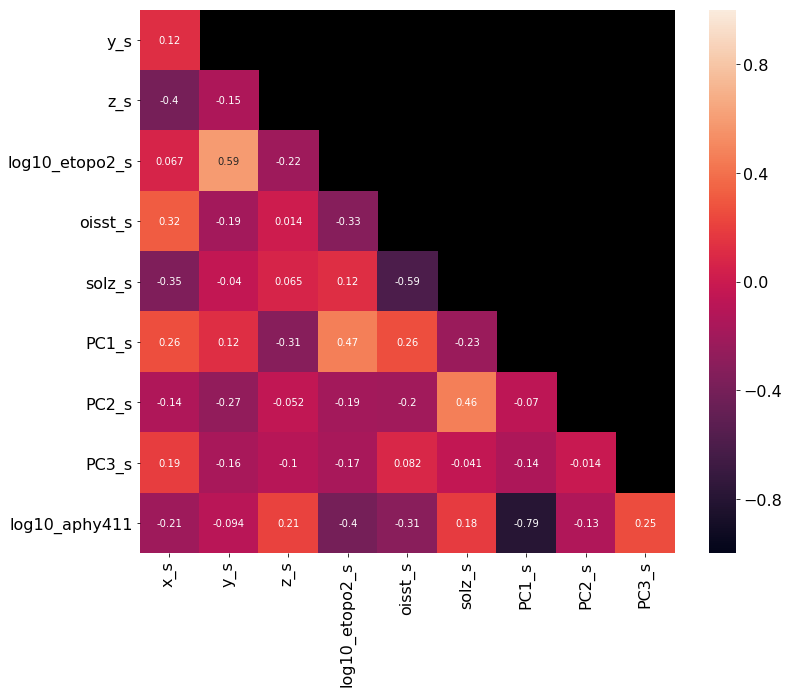

In [21]:
f, ax = pl.subplots(figsize=(12, 10))
plot_pairwise_corr(pd.concat((X_s, y), axis=1), ax=ax);

### Fitting w/ All Features

####  <u>Model 1: 2-Hidden Layer BNN -- 4 units/HL</u>

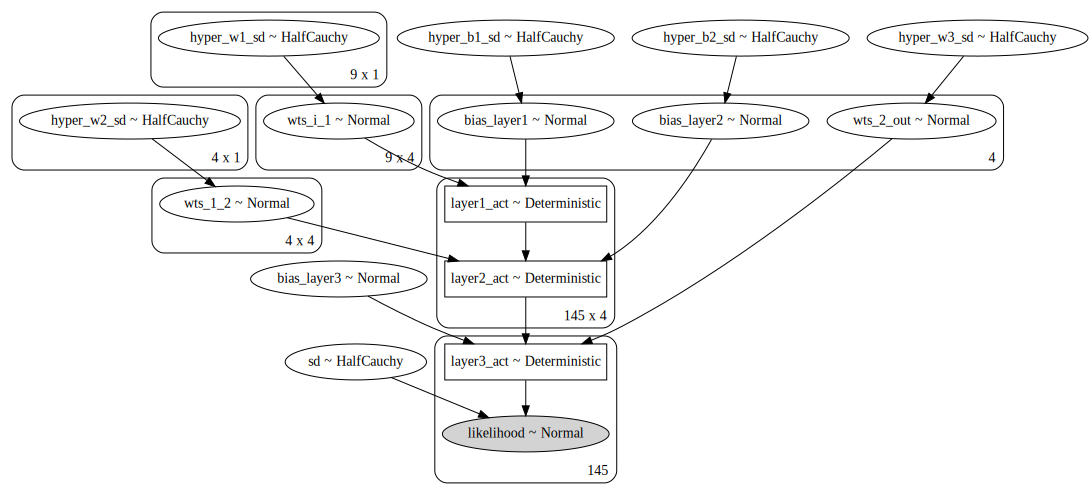

In [22]:
X_shared = shared(X_s_train.values)
bnn_l2_4_4HL = PyMCModel(bayes_nn_l2_h, X_shared, y_train, model_name='bnn_l2_4_4HL', n_hidden=(4, 4), include_bias=True)
bnn_l2_4_4HL.show_model()

In [23]:
bnn_l2_4_4HL.fit_ADVI(n_iter=100000, inference='svgd', inf_kwargs=dict(n_particles=500))

100%|██████████| 100000/100000 [2:18:19<00:00, 12.05it/s] 


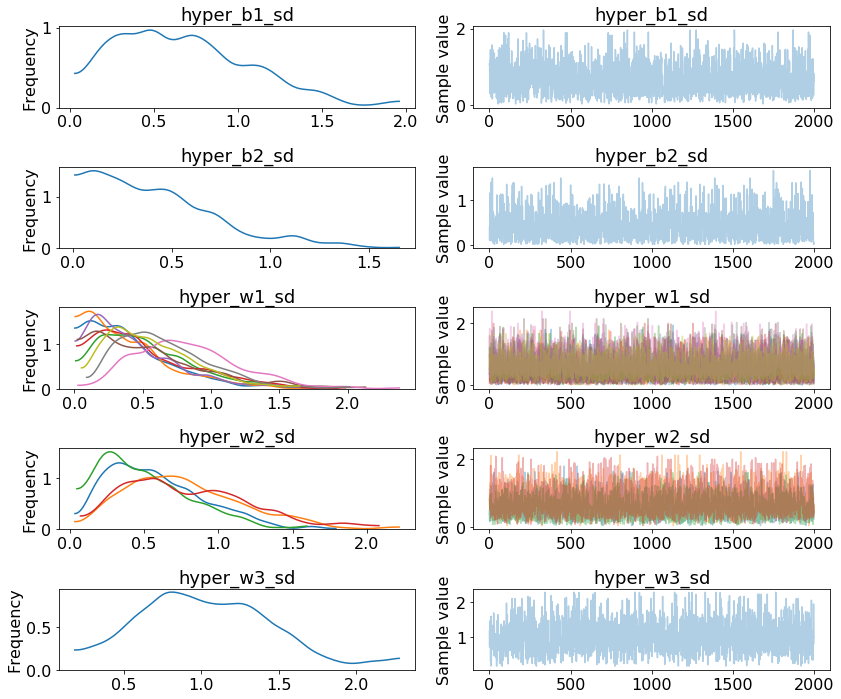

In [24]:
bnn_l2_4_4HL.evaluate_fit(['hyper_b1_sd', 'hyper_b2_sd', 'hyper_w1_sd', 'hyper_w2_sd', 'hyper_w3_sd']);

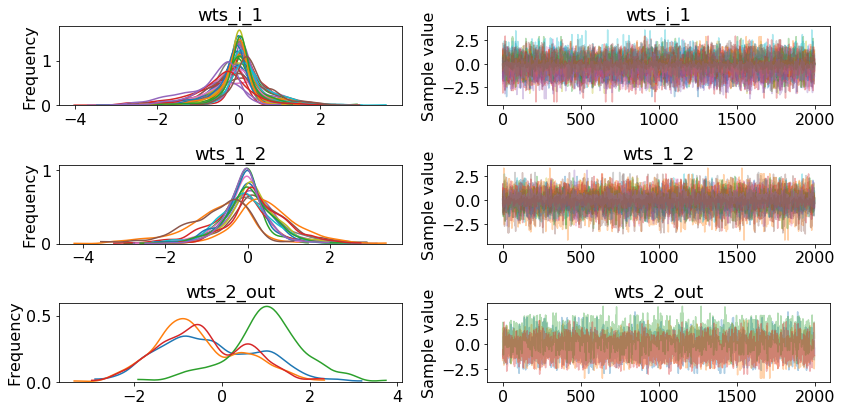

In [26]:
bnn_l2_4_4HL.evaluate_fit(['wts_i_1', 'wts_1_2', 'wts_2_out']);

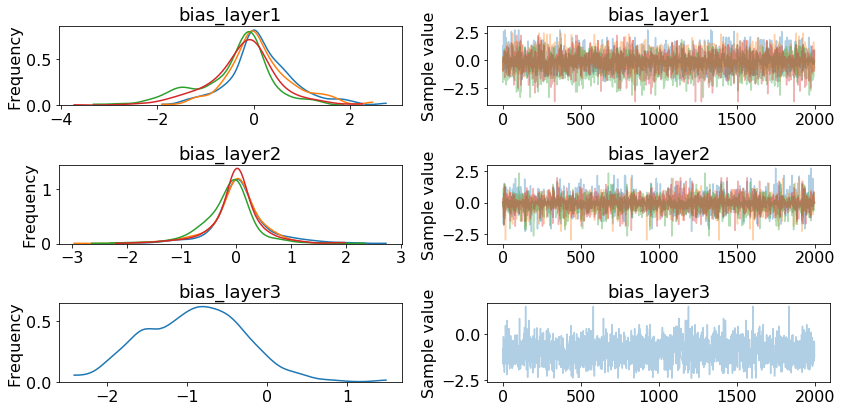

In [27]:
bnn_l2_4_4HL.evaluate_fit(['bias_layer1','bias_layer2', 'bias_layer3']);

100%|██████████| 2000/2000 [00:01<00:00, 1171.01it/s]


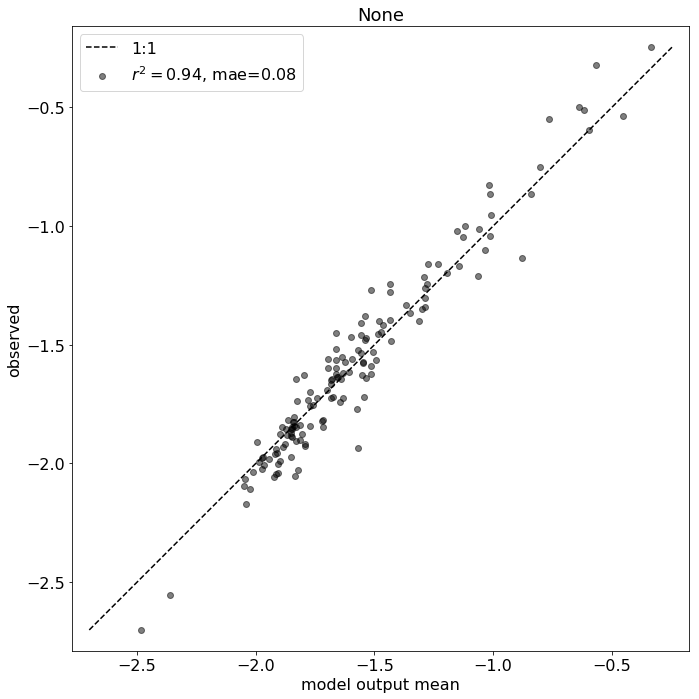

In [28]:
# Check fit on training model
ppc_train_l2_4_4HL = bnn_l2_4_4HL.predict(likelihood_name='likelihood')
bnn_l2_4_4HL.plot_model_fits(y_train, ppc_train_l2_4_4HL, loss_metric='mae', );

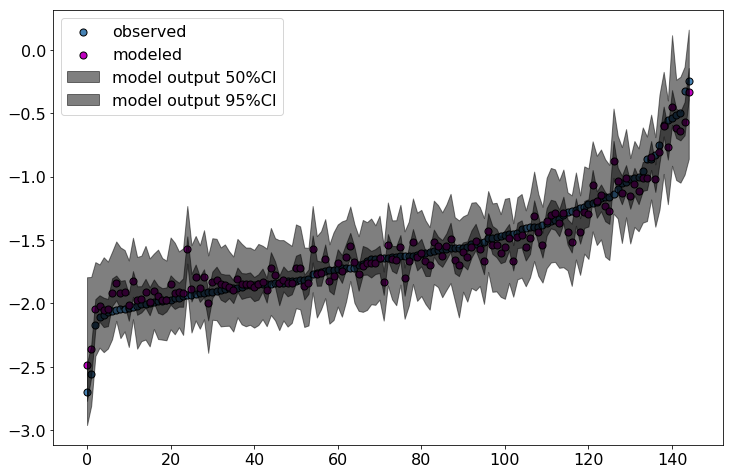

In [29]:
ax = plot_fits_with_unc(y_train, ppc_train_l2_4_4HL)

100%|██████████| 2000/2000 [00:02<00:00, 922.64it/s]


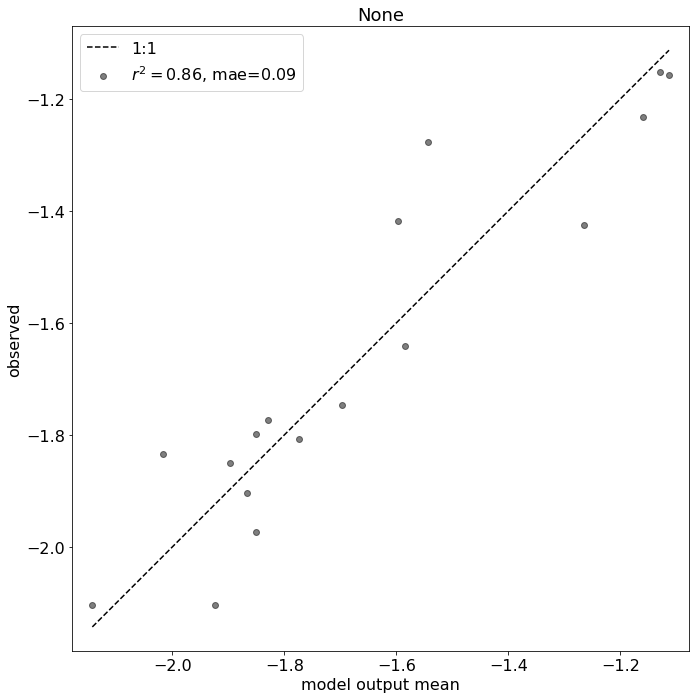

In [30]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l2_4_4HL = bnn_l2_4_4HL.predict(likelihood_name='likelihood')
bnn_l2_4_4HL.plot_model_fits(y_test, ppc_test_l2_4_4HL, loss_metric='mae',);

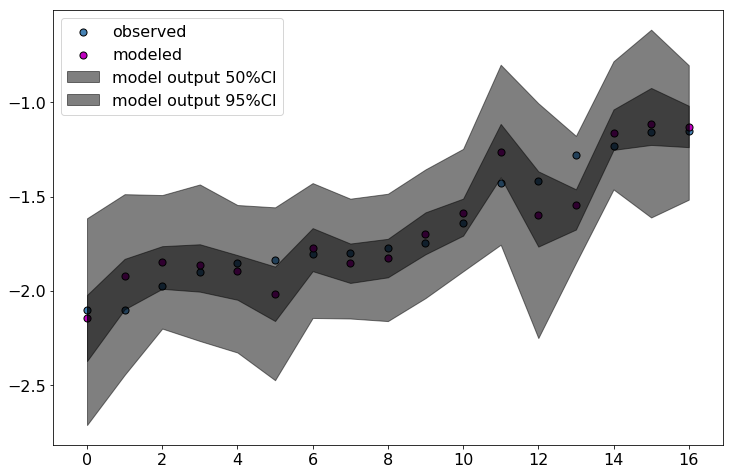

In [31]:
ax = plot_fits_with_unc(y_test, ppc_test_l2_4_4HL)

#### <u>Model 4: Double Layer ROBUST BNN (with Laplace Priors And Gaussian Likelihood) -- 4-4 HL</u>

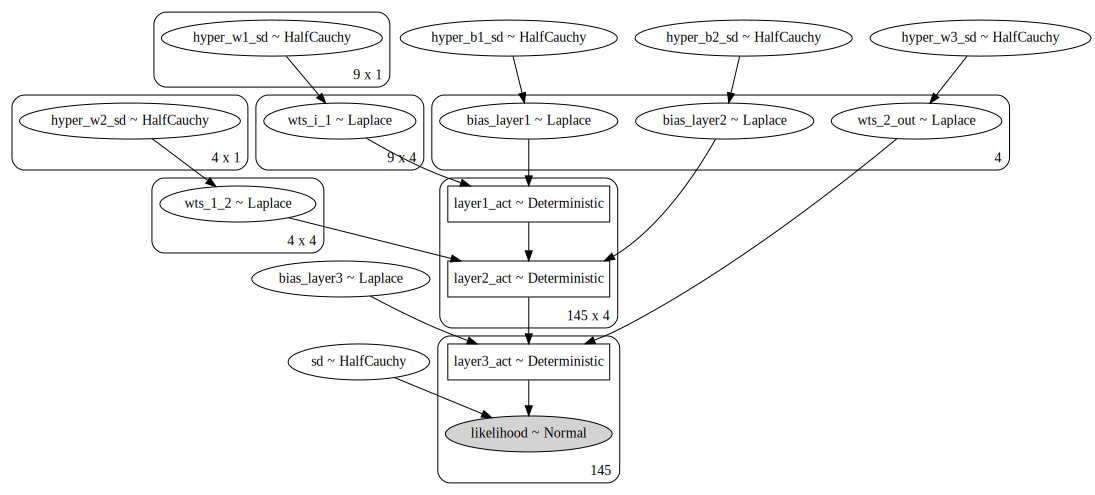

In [33]:
X_shared = shared(X_s_train.values)
bnn_l2_4_4HL_robust = PyMCModel(bayes_nn_l2_h_robust, X_shared, y_train, model_name='bnn_l2_HL_4_4_robust',
                                n_hidden=(4,4), include_bias=True)
bnn_l2_4_4HL_robust.show_model(save='./figJar/bnn_l2_4_4_robust')

In [35]:
bnn_l2_4_4HL_robust.fit_ADVI(n_iter=100000, inference='svgd', inf_kwargs=dict(n_particles=500))

100%|██████████| 100000/100000 [1:57:27<00:00, 14.19it/s]


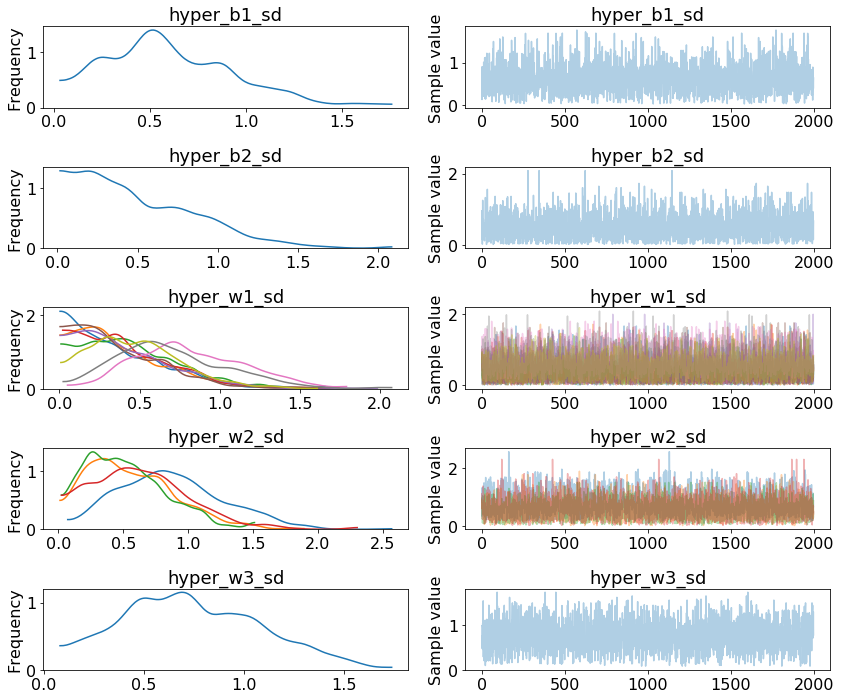

In [36]:
bnn_l2_4_4HL_robust.evaluate_fit(['hyper_b1_sd', 'hyper_b2_sd', 'hyper_w1_sd', 'hyper_w2_sd', 'hyper_w3_sd']);

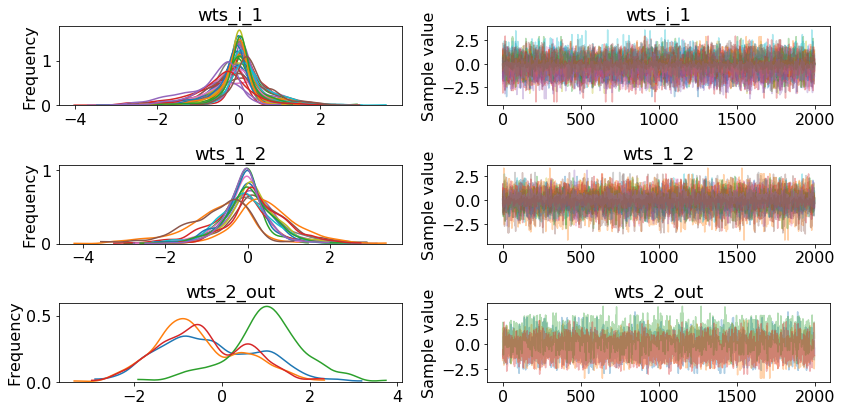

In [37]:
bnn_l2_4_4HL_robust.evaluate_fit(['wts_i_1', 'wts_1_2', 'wts_2_out']);

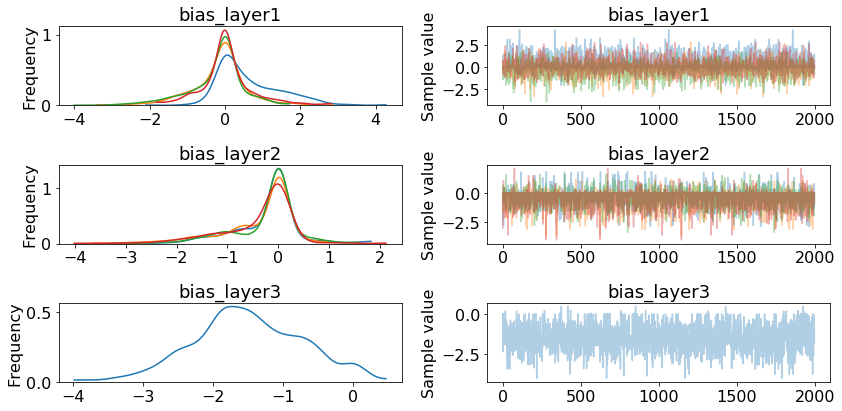

In [38]:
bnn_l2_4_4HL_robust.evaluate_fit(['bias_layer1','bias_layer2', 'bias_layer3']);

100%|██████████| 2000/2000 [00:01<00:00, 1233.45it/s]


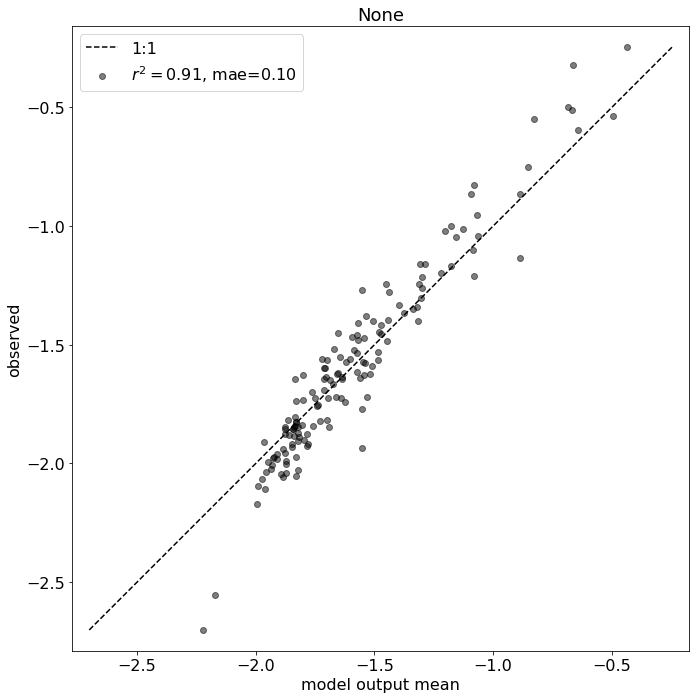

In [39]:
# Check fit on training model
ppc_train_l2_4_4HL_robust = bnn_l2_4_4HL_robust.predict(likelihood_name='likelihood')
bnn_l2_4_4HL_robust.plot_model_fits(y_train, ppc_train_l2_4_4HL_robust, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 916.08it/s]


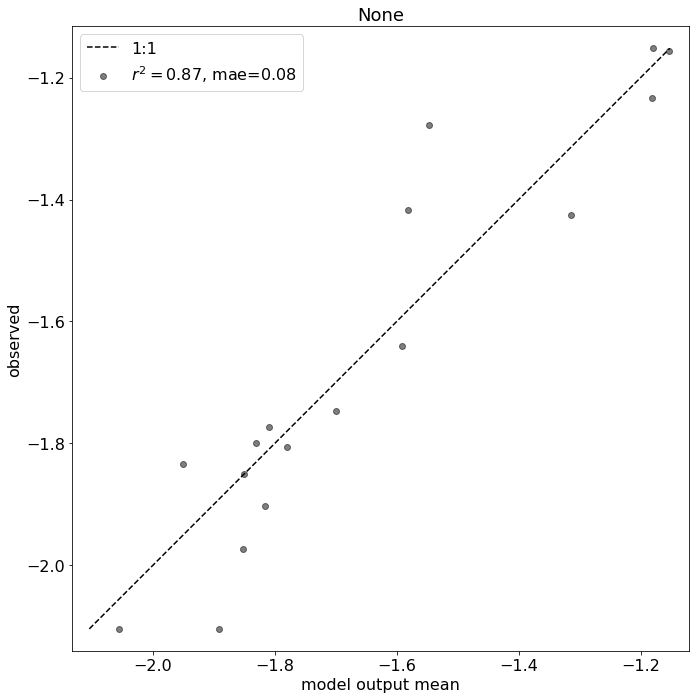

In [40]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l2_4_4HL_robust = bnn_l2_4_4HL_robust.predict(likelihood_name='likelihood')
bnn_l2_4_4HL_robust.plot_model_fits(y_test, ppc_test_l2_4_4HL_robust, loss_metric='mae',);

####  <u>Model 3: Double Layer BNN -- 8-8 units HL</u>

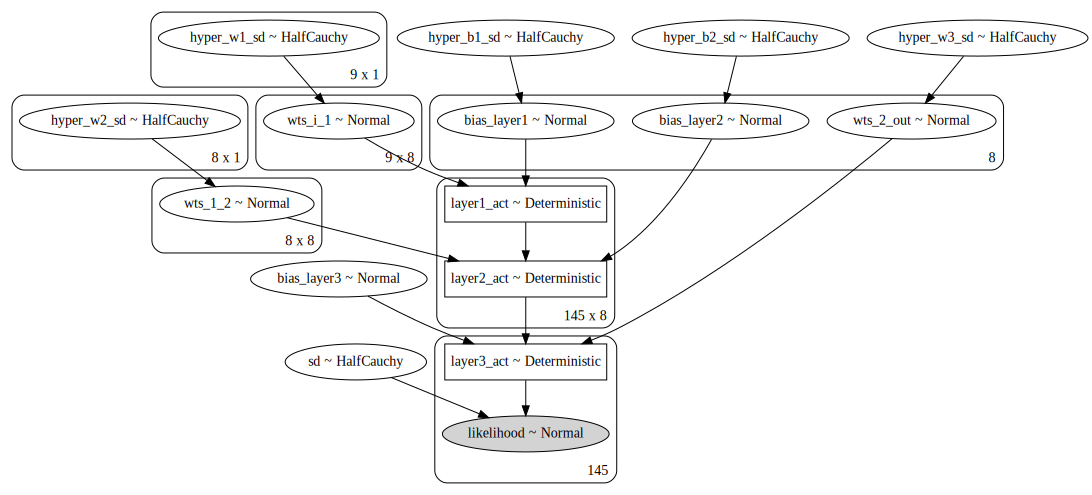

In [42]:
X_shared = shared(X_s_train.values)
bnn_l2_8_8HL = PyMCModel(bayes_nn_l2_h, X_shared, y_train, n_hidden=(8,8), include_bias=True)
bnn_l2_8_8HL.show_model()

In [ ]:
bnn_l2_8_8HL.fit_ADVI(n_iter=100000, inference='svgd', inf_kwargs=dict(n_particles=500))

  6%|▌         | 5598/100000 [11:20<3:11:10,  8.23it/s]

In [ ]:
bnn_l2_8_8HL.evaluate_fit(['hyper_b1_sd', 'hyper_b2_sd', 'hyper_w1_sd', 'hyper_w2_sd', 'hyper_w3_sd']);

In [ ]:
bnn_l2_8_8HL.evaluate_fit(['wts_i_1', 'wts_1_2', 'wts_2_out']);

In [ ]:
bnn_l2_8_8HL.evaluate_fit(['bias_layer1','bias_layer2', 'bias_layer3']);

In [ ]:
# Check fit on training model
ppc_train_l2_8_8HL = bnn_l2_8_8HL.predict(likelihood_name='likelihood')
bnn_l2_8_8HL.plot_model_fits(y_train, ppc_train_l2_8_8HL, loss_metric='mae', );

In [ ]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l2_8_8HL = bnn_l2_8_8HL.predict(likelihood_name='likelihood')
bnn_l2_8_8HL.plot_model_fits(y_test, ppc_test_l2_8_8HL, loss_metric='mae',);

#### <u>Model 4: Double Layer ROBUST BNN (with Laplace Priors And Gaussian Likelihood) -- 8-8 HL</u>

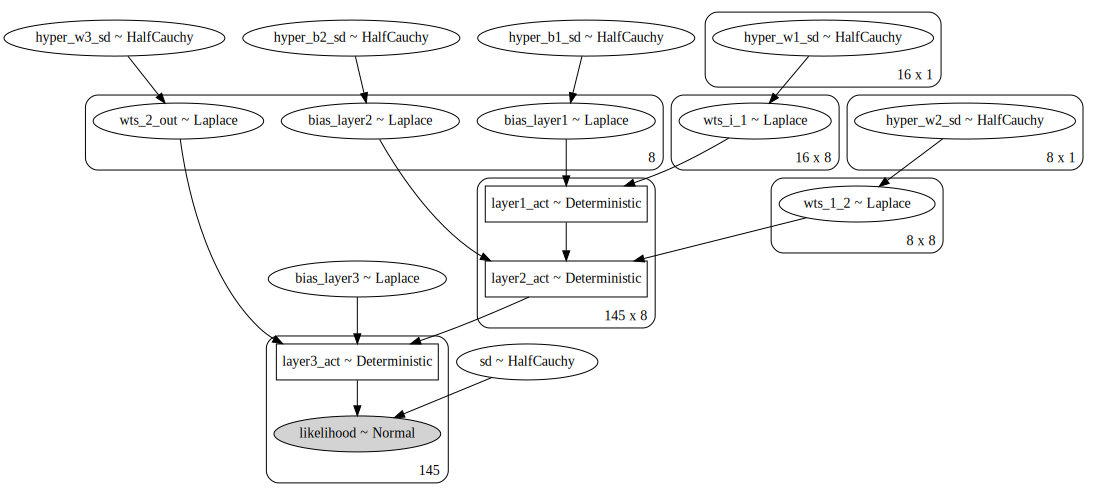

In [109]:
X_shared = shared(X_s_train.values)
bnn_l2_8_8HL_robust = PyMCModel(bayes_nn_l2_h_robust, X_shared, y_train, model_name='bnn_l2_HL_8_8_robust',
                                n_hidden=(8,8), include_bias=True)
bnn_l2_8_8HL_robust.show_model()

In [110]:
bnn_l2_8_8HL_robust.fit_ADVI(inference='svgd', inf_kwargs=dict(n_particles=500))

100%|██████████| 100000/100000 [2:12:02<00:00, 12.62it/s] 


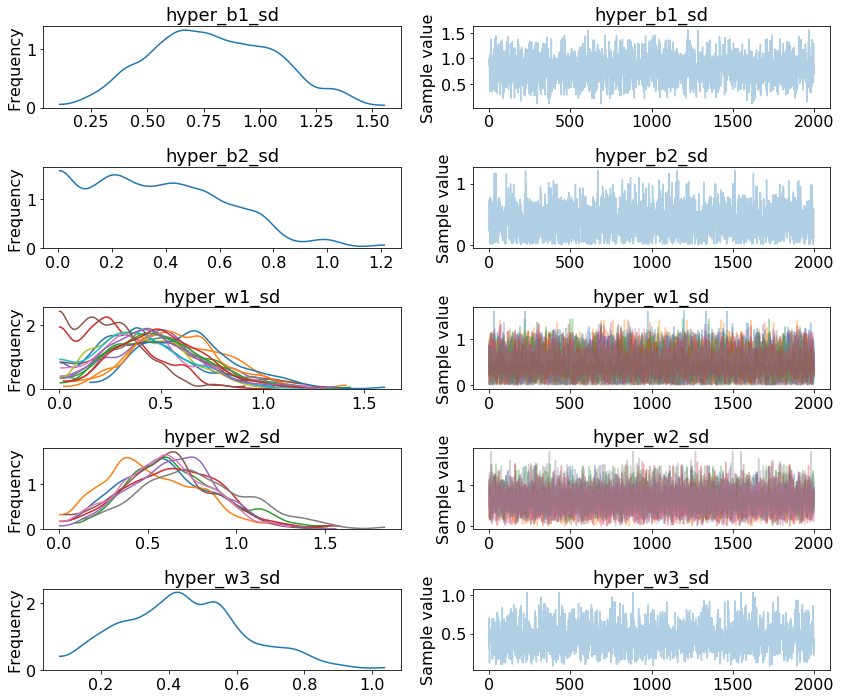

In [111]:
bnn_l2_8_8HL_robust.evaluate_fit(['hyper_b1_sd', 'hyper_b2_sd', 'hyper_w1_sd', 'hyper_w2_sd', 'hyper_w3_sd']);

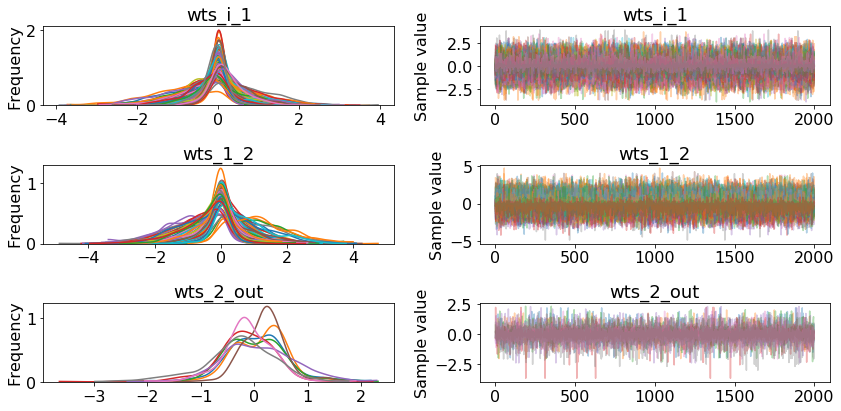

In [112]:
bnn_l2_8_8HL_robust.evaluate_fit(['wts_i_1', 'wts_1_2', 'wts_2_out']);

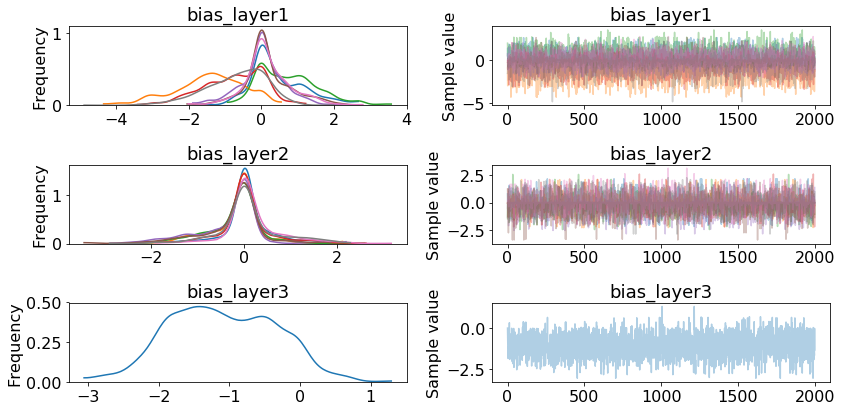

In [113]:
bnn_l2_8_8HL_robust.evaluate_fit(['bias_layer1','bias_layer2', 'bias_layer3']);

100%|██████████| 2000/2000 [00:01<00:00, 1231.24it/s]


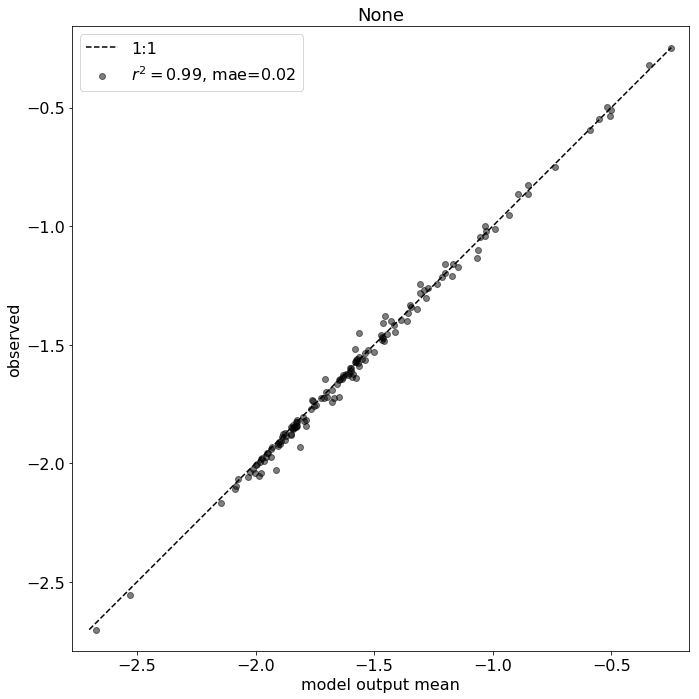

In [117]:
# Check fit on training model
ppc_train_l2_8_8HL_r = bnn_l2_8_8HL_robust.predict(likelihood_name='likelihood')
bnn_l2_8_8HL_robust.plot_model_fits(y_train, ppc_train_l2_8_8HL_r, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 908.85it/s]


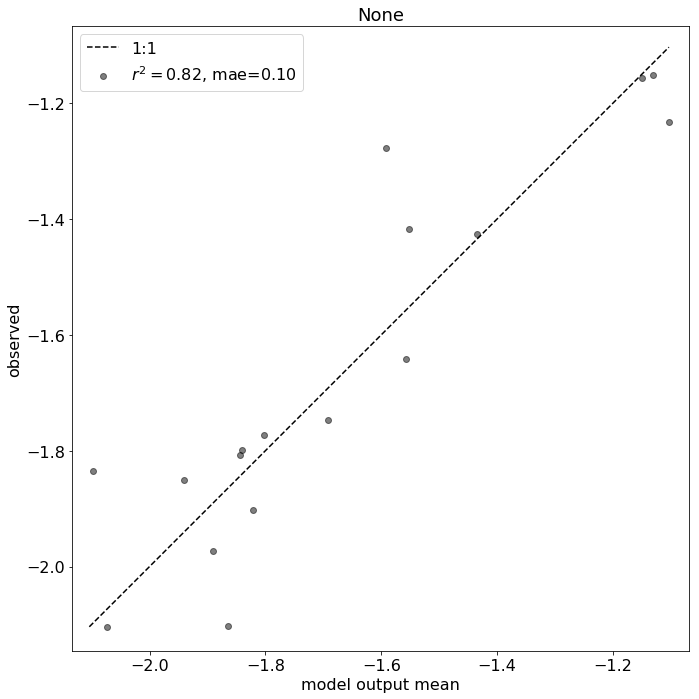

In [115]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l2_8_8HL_r = bnn_l2_8_8HL_robust.predict(likelihood_name='likelihood')
bnn_l2_8_8HL_robust.plot_model_fits(y_test, ppc_test_l2_8_8HL_r, loss_metric='mae',);

#### <u>Model 5: Double Layer ROBUST BNN (with Laplace Priors And StudentT Likelihood) -- 8-8 HL</u>

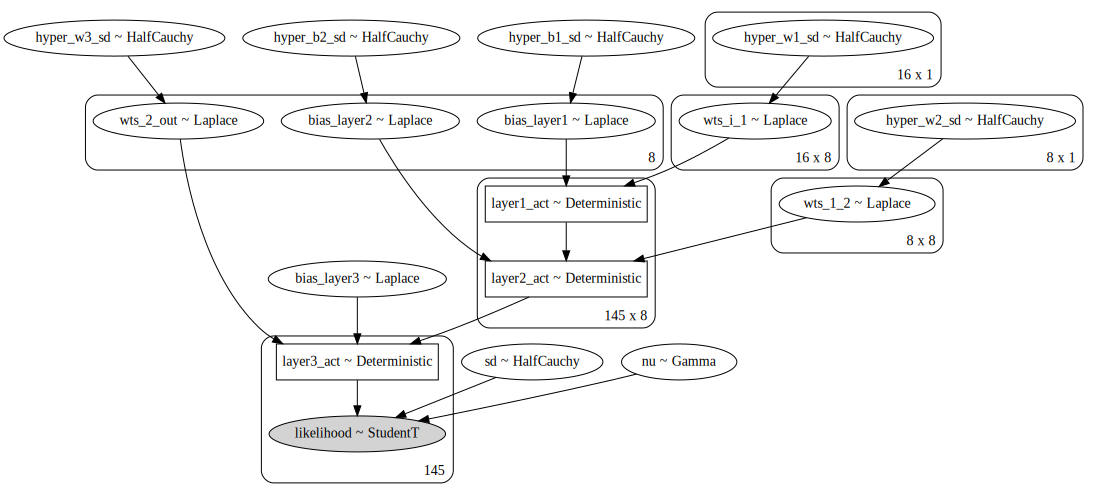

In [122]:
X_shared = shared(X_s_train.values)
bnn_l2_8_8HL_robust_s = PyMCModel(bayes_nn_l2_h_robust_studentT, X_shared, y_train, model_name='bnn_l2_HL_8_8_robust',
                                n_hidden=(8,8), include_bias=True)
bnn_l2_8_8HL_robust_s.show_model()

In [123]:
bnn_l2_8_8HL_robust_s.fit_ADVI(n_iter=100000, inference='svgd', inf_kwargs=dict(n_particles=500))

100%|██████████| 100000/100000 [2:18:39<00:00, 12.02it/s] 


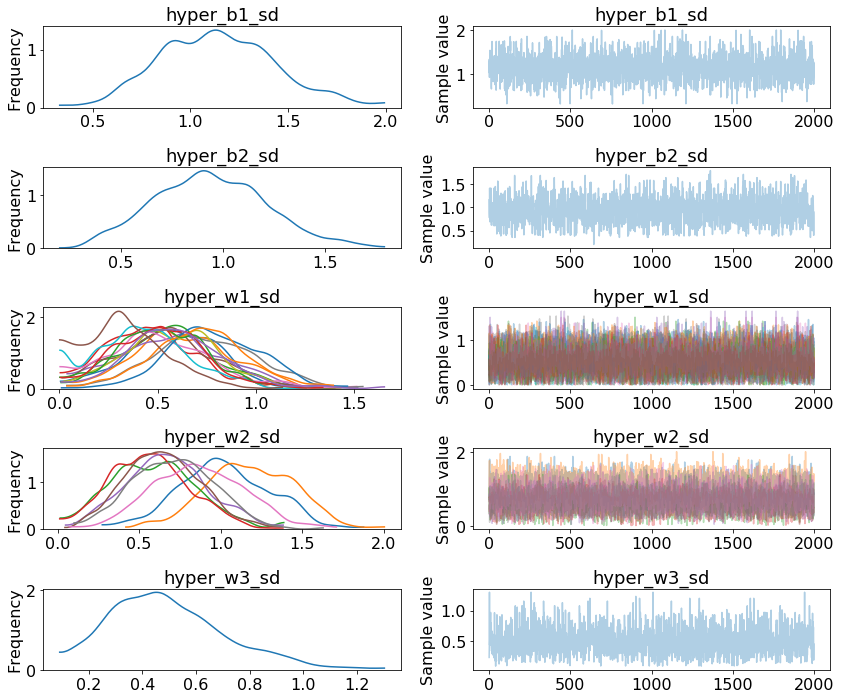

In [124]:
bnn_l2_8_8HL_robust_s.evaluate_fit(['hyper_b1_sd', 'hyper_b2_sd', 'hyper_w1_sd', 'hyper_w2_sd', 'hyper_w3_sd']);

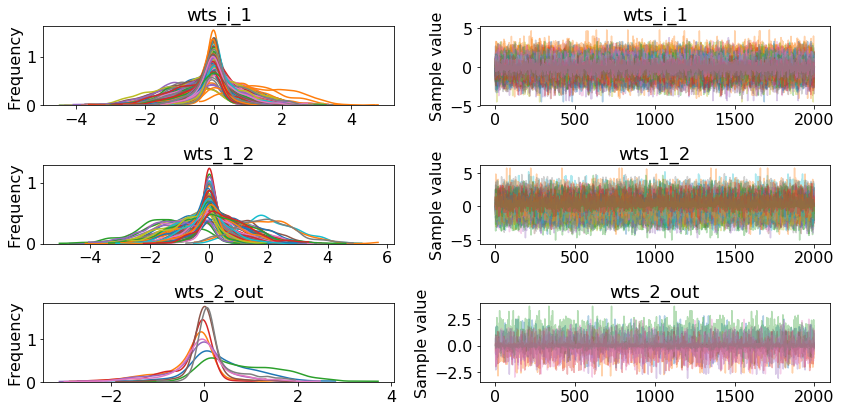

In [125]:
bnn_l2_8_8HL_robust_s.evaluate_fit(['wts_i_1', 'wts_1_2', 'wts_2_out']);

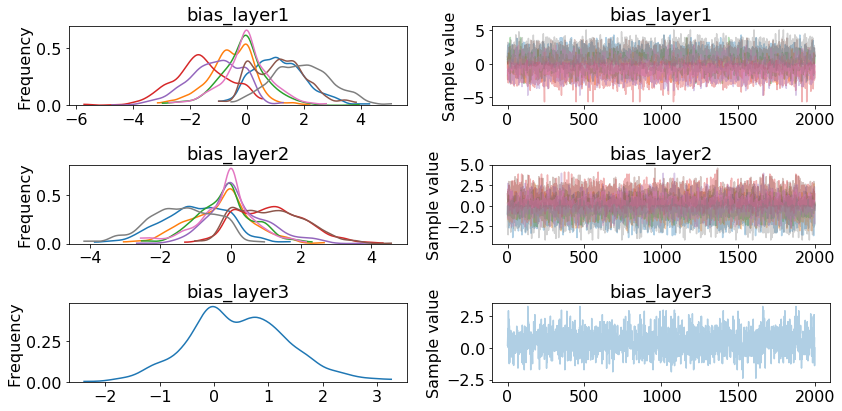

In [126]:
bnn_l2_8_8HL_robust_s.evaluate_fit(['bias_layer1','bias_layer2', 'bias_layer3']);

100%|██████████| 2000/2000 [00:01<00:00, 1167.58it/s]


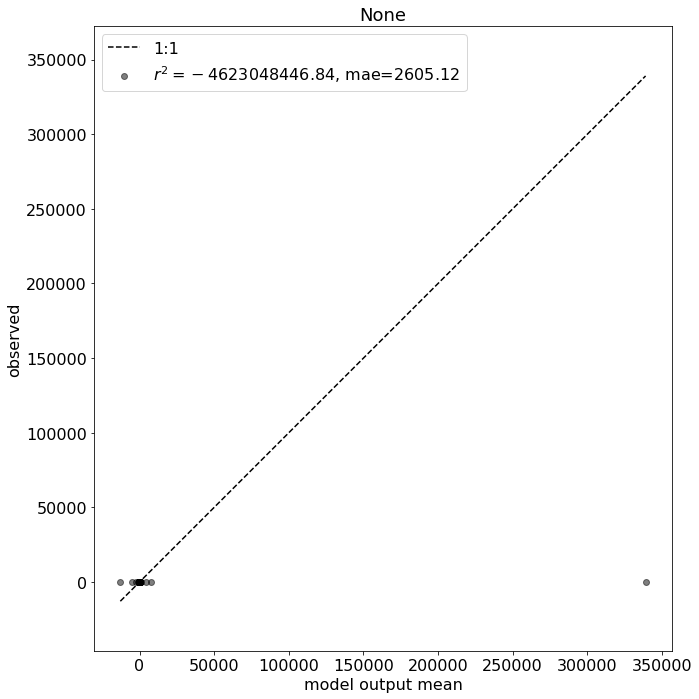

In [127]:
# Check fit on training model
ppc_train_l2_8_8HL_rs = bnn_l2_8_8HL_robust_s.predict(likelihood_name='likelihood')
bnn_l2_8_8HL_robust_s.plot_model_fits(y_train, ppc_train_l2_8_8HL_rs, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 972.54it/s]


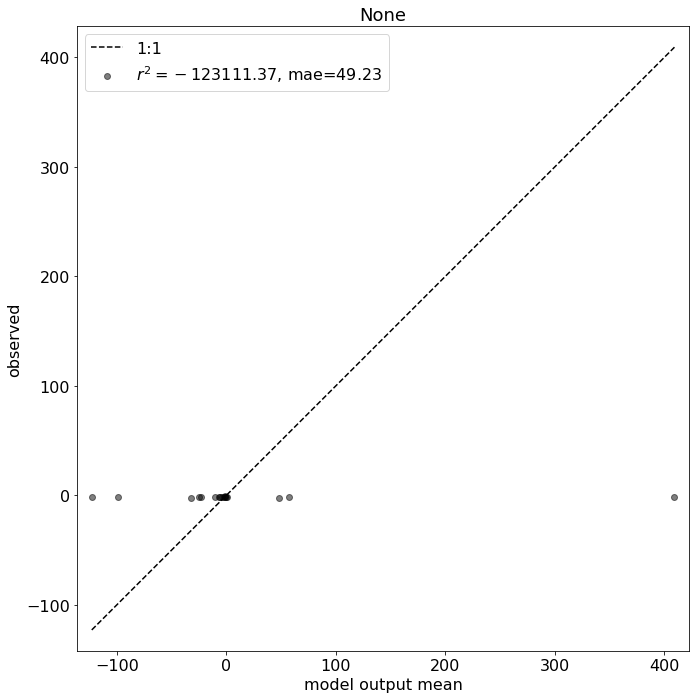

In [128]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l2_8_8HL_rs = bnn_l2_8_8HL_robust_s.predict(likelihood_name='likelihood')
bnn_l2_8_8HL_robust_s.plot_model_fits(y_test, ppc_test_l2_8_8HL_rs, loss_metric='mae',);

In [41]:
bnn_l2_4_4HL.model.name = 'bnn_l2_4_4HL'
bnn_l2_4_4HL_robust.model.name='bnn_l2_4_4HL_r_NL'
bnn_l2_8_8HL.model.name = 'bnn_l2_8_8HL'
bnn_l2_8_8HL_robust.model.name= 'bnn_l2_8_8HL_r_NL'
bnn_l2_8_8HL_robust_s.model.name = 'bnn_l2_8_8HL_r_SL'

NameError: name 'bnn_l2_8_8HL' is not defined

In [ ]:
pickledModelDict = {bnn_l2.model.name: bnn_l2,
                   bnn_l2_8_8HL.model.name: bnn_l2_8_8HL,
                    bnn_l2_8_8HL_robust.model.name: bnn_l2_8_8HL_robust,
                    bnn_l2_8_8HL_robust_s.model.name: bnn_l2_8_8HL_robust_s,
                   }
with open('./pickleJar/Models/Aphi%d_BNN_2HL_ARD_SVGD_reduced_dataset.pkl' % band, 'wb') as f:
    pickle.dump(pickledModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)